# Nonlinear Image Registration Example

This notebook demonstrates a complete workflow for performing nonlinear (deformable) image registration using the ClearEx library. The process includes:

1. **Data preparation**: Loading fixed and moving images
2. **Linear alignment**: Applying pre-computed affine transformations
3. **ROI optimization**: Cropping to overlapping regions
4. **Nonlinear registration**: Computing deformable transformations
5. **Post-processing**: Histogram matching and displacement field analysis

## Overview

Nonlinear registration is essential for aligning images with complex, localized deformations that cannot be captured by linear transformations alone. This example uses ANTs (Advanced Normalization Tools) for high-accuracy registration.

---

## 1. Import Dependencies

In [1]:
%%time
# Standard library imports
import os

# Third-party imports
import ants
import numpy as np
import tifffile
import matplotlib.pyplot as plt

# ClearEx library imports
import clearex
from clearex.registration.common import import_affine_transform
from clearex.registration.linear import transform_image
import clearex.file_operations.tools as tools
from clearex.plot.images import mips
from tests import download_test_registration_data


CPU times: user 12.5 s, sys: 415 ms, total: 12.9 s
Wall time: 3 s


---

## 2. Download and Prepare Test Data

Download example registration data for this demonstration. This includes:
- Fixed image (reference/target image)
- Moving image (image to be registered)
- Pre-computed affine transformation matrix

In [2]:
%%time
output_path = download_test_registration_data()


Test data already exists at /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data. Skipping download.
CPU times: user 970 μs, sys: 2 μs, total: 972 μs
Wall time: 2.49 ms


---

## 3. Load Images and Transformation

Load the fixed and moving images along with the pre-computed affine transformation matrix. The affine transformation provides an initial linear alignment before applying nonlinear registration.

In [3]:
%%time
# Define file paths for fixed and moving images
fixed_path = os.path.join(
    output_path,
    "cropped_fixed.tif")

moving_path = os.path.join(
    output_path,
    "cropped_moving.tif")

transform_path = os.path.join(
    output_path,
    "GenericAffine.mat")

transform_list = [transform_path]

# Load the fixed image (reference)
print(f"Loading fixed image: {fixed_path}")
fixed_roi = tifffile.imread(fixed_path)

# Load the moving image (to be registered)
print(f"Loading moving image: {moving_path}")
moving_roi = tifffile.imread(moving_path)
print("Image shape:", moving_roi.shape)

Loading fixed image: /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data/cropped_fixed.tif
Loading moving image: /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data/cropped_moving.tif
Image shape: (925, 163, 306)
CPU times: user 44.6 ms, sys: 53 ms, total: 97.5 ms
Wall time: 111 ms


---

## 4. Import and Apply Affine Transformation

The affine transformation serves as an initial coarse alignment. This step brings the moving image into approximate correspondence with the fixed image before performing nonlinear registration.

In [4]:
%%time
# Import the pre-computed affine transformation matrix
print(f"Importing affine transform from: {transform_path}")
transform = import_affine_transform(transform_path)

Importing affine transform from: /endosome/archive/bioinformatics/Danuser_lab/Dean/dean/git/clearex/downloaded_data/GenericAffine.mat
CPU times: user 2.12 ms, sys: 35 μs, total: 2.16 ms
Wall time: 2.41 ms


### Apply Linear Transformation

Apply the affine transformation to the moving image to achieve initial alignment.

In [5]:
%%time
print("Applying transform to moving image...")
transformed_image = transform_image(moving_roi, fixed_roi, transform)

Applying transform to moving image...
CPU times: user 5.9 s, sys: 296 ms, total: 6.19 s
Wall time: 6.21 s


---

## 5. Optimize Region of Interest (ROI)

Crop both images to their overlapping region to focus computational resources on relevant data. This step uses robust percentile-based thresholding to identify the minimal bounding box containing valid image data.

In [6]:
%%time
print("Identifying smallest ROI that encapsulates the data.")
print("The original data shape:", fixed_roi.shape)

# Crop to overlapping region using robust percentile thresholding
fixed_roi, transformed_image, bounding_box = tools.crop_overlapping_datasets(
    fixed_roi,
    transformed_image,
    robust=True,
    lower_pct=3,      # Lower percentile for intensity thresholding
    upper_pct=97,     # Upper percentile for intensity thresholding
)
print(f"The cropped data shape: {fixed_roi.shape}")


Identifying smallest ROI that encapsulates the data.
The original data shape: (925, 163, 306)
The cropped data shape: (610, 136, 291)
CPU times: user 282 ms, sys: 94.6 ms, total: 377 ms
Wall time: 377 ms


### Visualize Initial Alignment

Display maximum intensity projections (MIPs) to visually assess the quality of the affine alignment before proceeding to nonlinear registration.

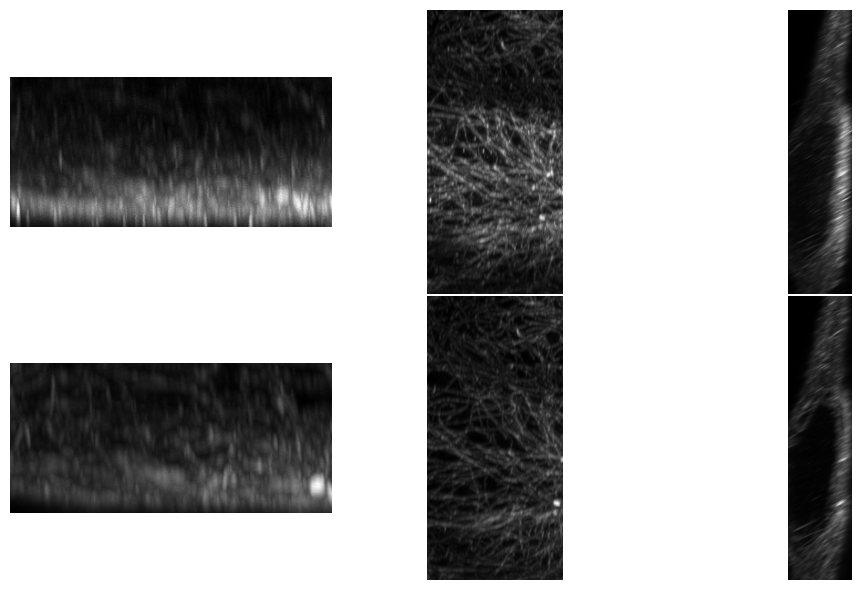

In [7]:
mips(fixed_roi, transformed_image)

---

## 6. Perform Nonlinear Registration

Compute a deformable (nonlinear) transformation to capture local tissue deformations. This step uses ANTs SyN (Symmetric Normalization) algorithm with high accuracy settings for optimal alignment.

**Note**: This step is computationally intensive and may take several minutes depending on image size and hardware.

In [8]:
%%time
# Perform nonlinear registration with low accuracy settings
nonlinear_transformed, transform_path = clearex.registration.nonlinear.register_image(
        moving_image=moving_roi,
        fixed_image=fixed_roi,
        accuracy="low",  # Options: "low", "medium", "high"
        verbose=True,
)

print("The nonlinear transform is located at:", transform_path)


antsRegistration --dimensionality 3 -r Identity --metric mattes[0x7fdb19babce8,0x7fdb19bab428,1,32] --transform SyN[0.200000,3.000000,0.500000] --convergence [5x5x5,1e-7,8] --smoothing-sigmas 2x1x0 --shrink-factors 4x2x1 -u 0 -z 1 --output [/tmp/tmps2li81g8,0x7fdb19baaea8,0x7fdb19baaec8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Identity (type = MatrixOffsetTransformBase)
  Reading mask(s).
    Registration stage 0
      No fixed mask
      No moving mask
  number of levels = 3
  fixed image: 0x7fdb19babce8
  moving image: 0x7fdb19bab428
Dimension = 3
Number of stages = 1
Use histogram matching = false
Winsorize image intensities = false
  Lower quantile = 0
  Upper quantile = 1


Stage 1 State
   Image metric = MattesMI
     Fixed image = Image (0x555820208750)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 2
  Modified T

### Inspect Registration Results

Examine the output dictionary containing the warped image and transformation parameters.

In [15]:
%%time
nonlinear_transformed

CPU times: user 0 ns, sys: 43 μs, total: 43 μs
Wall time: 97 μs


ANTsImage (RAI)
	 Pixel Type : unsigned int (uint32)
	 Components : 1
	 Dimensions : (610, 136, 291)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

---

## 7. Apply Histogram Matching

Adjust the intensity distribution of the warped image to match the reference image. This post-processing step improves visual consistency and is useful for downstream quantitative analysis.

Histogram matching ensures that corresponding anatomical structures have similar intensity values, which is particularly important for comparison and visualization.

In [9]:
%%time
print("Histogram matching the warped data to the original data.")

# Convert the transformed image to ANTs format
transformed_image = ants.from_numpy(transformed_image)

# Match the intensity histogram of the warped image to the reference
warped_image = ants.histogram_match_image(
    source_image=nonlinear_transformed['warpedmovout'],
    reference_image=transformed_image
    # Optional parameters:
    # number_of_match_points=64,
    # use_threshold_at_mean_intensity=True
)


Histogram matching the warped data to the original data.
CPU times: user 2.64 s, sys: 87.7 ms, total: 2.73 s
Wall time: 2.74 s


---

## 8. Analyze and Visualize Displacement Field

Quantify the magnitude of deformation by computing displacement statistics from the nonlinear transformation. The displacement field represents the vector field that maps each voxel in the moving image to its corresponding location in the fixed image.

This analysis provides insights into:
- **Average displacement**: Overall magnitude of deformation
- **Maximum displacement**: Regions with largest local deformations
- **Spatial patterns**: Visualization of deformation vectors

Calculating average displacement amplitude.
Average displacement: 0.32 mm
Maximum displacement: 3.41 mm


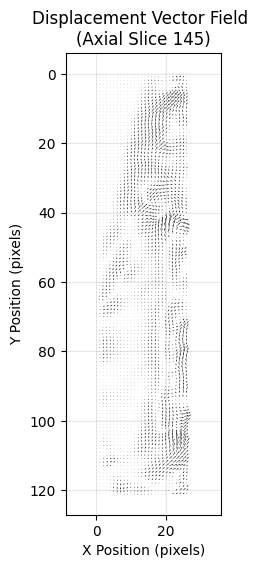

In [15]:
print("Calculating average displacement amplitude.")

# Load and analyze the warp field
warp = ants.image_read(transform_path).numpy()

# Calculate displacement magnitude at each voxel
mag = np.linalg.norm(warp, axis=-1)

# Compute summary statistics
avg_disp = mag.mean()
max_disp = mag.max()
print(f"Average displacement: {avg_disp:.2f} mm")
print(f"Maximum displacement: {max_disp:.2f} mm")

# Extract displacement components sfor visualization (middle axial slice)
z = warp.shape[2] // 2
u = warp[:, :, z, 0]  # X-component of displacement
v = warp[:, :, z, 1]  # Y-component of displacement

# Visualize displacement vectors
plt.figure(figsize=(2, 6))
plt.quiver(u[::5, ::5], v[::5, ::5], scale_units='xy')  # Subsample for clarity
plt.title(f"Displacement Vector Field \n(Axial Slice {z})")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.gca().invert_yaxis()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()